In [ ]:
#https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [100]:
from tqdm import tqdm
from tabulate import tabulate
from matplotlib import pyplot as plt

In [6]:
# selecting random number of images from multiple folders and copying it to the destination folder
# Combined Prediction (take new sample and make combine data)

import os
import shutil
import glob
import random
# ctscan_covid_data = random.sample(glob.glob("Custom_Data/CT_Scan/Covid/CT_COVID/*.png"), 330)
# ctscan_normal_data = random.sample(glob.glob("Custom_Data/CT_Scan/Normal/CT_nonCOVID/*"), 330)

# ultrasound_covid_data = random.sample(glob.glob("Custom_Data/ultrasound/Covid/*"), 330)
# ultrasound_normal_data = random.sample(glob.glob("Custom_Data/ultrasound/Normal/*.jpg"), 330)

# xray_covid_data = random.sample(glob.glob("Custom_Data/X_ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Custom_Data/X_ray/Normal/*.png"), 330)

ctscan_covid_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Covid/*.png"), 330)
ctscan_normal_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Normal/*"), 330)   

ultrasound_covid_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Covid/*"), 330)
ultrasound_normal_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Normal/*.jpg"), 330)

xray_covid_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Covid/*.png"), 330)
xray_normal_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Normal/*.png"), 330)

covid_list=[ctscan_covid_data,ultrasound_covid_data,xray_covid_data]

normal_list = [ctscan_normal_data, ultrasound_normal_data,xray_normal_data]

if os.path.isdir('Data/Covid'):
    shutil.rmtree('Data/Covid')
    
if os.path.isdir('Data/Normal'):
    shutil.rmtree('Data/Normal')

for data in covid_list:
    dest = 'Data/Covid'
    if not os.path.isdir('Data/Covid'):
        os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

for data in normal_list:
    dest = 'Data/Normal' 
    if not os.path.isdir('Data/Normal'):
          os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

In [6]:
# pre-processing (image shape)
# X shape in 3 dimensions
# Y has 2 classes (Covid, Normal)
# make train and test data

class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X_train, self.X_test, self.labels_train, self.labels_test, self.y_train, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [7]:
# (660*3) * 0.7 = 1386
import os
import shutil
import glob
import random
data = Dataset("Data/", test_size=0.3, img_size=224)
print(data.X_train.shape, data.y_train.shape)
print(data.X_test.shape, data.y_test.shape)

(1386, 224, 224, 3) (1386, 2)
(594, 224, 224, 3) (594, 2)


In [13]:
print(data.X_train.shape[1:4])

(224, 224, 3)


In [15]:
mobinet_model = tf.keras.applications.MobileNetV2(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

In [16]:
resnet_model = tf.keras.applications.ResNet101V2(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

171327488/171317808 [==============================] - 365s 2us/step


In [18]:
vgg_model = tf.keras.applications.vgg19.VGG19(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 188s 2us/step


In [10]:
# feature extractor model resnet 101 v2
# model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)

In [93]:
covid_train_embedding = mobinet_model(data.X_train)
#covid_test_embedding = mobinet_model(data.X_test)
print(covid_train_embedding.shape)

KeyboardInterrupt: 

In [27]:
mobinet_model.trainable = False
mobinet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [94]:
# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)
# dataset = tf.keras.utils.image_dataset_from_directory("Data",
#                                                       shuffle=True,
#                                                       batch_size=BATCH_SIZE,
#                                                       image_size=IMG_SIZE)

In [30]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [31]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(covid_train_embedding)
print(feature_batch_average.shape)

(1386, 1280)


In [84]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1386, 2)


In [89]:
# Model

inputs = tf.keras.Input(shape=(data.X_train.shape[1:4]))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = mobinet_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [90]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [35]:
len(model.trainable_variables)

2

In [45]:
print(covid_train_embedding.shape)
print(feature_batch_average.shape)

(1386, 7, 7, 1280)
(1386, 1280)


In [48]:
# X_train_val = covid_train_embedding
# y_train_val = data.y_train
# data_train_labels = data.labels_train

In [49]:
# X_test_val = covid_test_embedding
# y_test_val = data.y_test
# data_test_labels = data.labels_test

In [50]:
# # Chaning shape for CNN2D
# # for 2048 - > [-1,2,2,512]
# # for 1280 - > [-1,2,2,320]

# covid_train_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_train_embedding2d.shape)

# covid_test_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_test_embedding2d.shape)

# X_train_val = covid_train_embedding2d
# X_test_val = covid_test_embedding2d

(1386, 2, 2, 320)
(1386, 2, 2, 320)


In [92]:
initial_epochs = 10
history = model.fit(data.X_train, data.y_train, epochs=initial_epochs, validation_data=(data.X_test, data.y_test))

Epoch 1/10
44/44 [==============================] - 83s 2s/step - loss: 0.7700 - accuracy: 0.5281 - val_loss: 0.7218 - val_accuracy: 0.5303
Epoch 2/10
44/44 [==============================] - 76s 2s/step - loss: 0.7390 - accuracy: 0.5527 - val_loss: 0.6896 - val_accuracy: 0.5943
Epoch 3/10
44/44 [==============================] - 76s 2s/step - loss: 0.7067 - accuracy: 0.6053 - val_loss: 0.6668 - val_accuracy: 0.6313
Epoch 4/10
44/44 [==============================] - 73s 2s/step - loss: 0.7023 - accuracy: 0.6039 - val_loss: 0.6475 - val_accuracy: 0.6650
Epoch 5/10
44/44 [==============================] - 71s 2s/step - loss: 0.6617 - accuracy: 0.6623 - val_loss: 0.6292 - val_accuracy: 0.6919
Epoch 6/10
44/44 [==============================] - 81s 2s/step - loss: 0.6532 - accuracy: 0.6602 - val_loss: 0.6134 - val_accuracy: 0.7104
Epoch 7/10
44/44 [==============================] - 74s 2s/step - loss: 0.6516 - accuracy: 0.6674 - val_loss: 0.6026 - val_accuracy: 0.7189
Epoch 8/10
44/44 [==

TypeError: Invalid keyword arguments: {'validation_data': (array([[[[ 23.,  23.,  23.],
         [ 28.,  28.,  28.],
         [ 28.,  28.,  28.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 27.,  27.,  27.],
         [ 33.,  33.,  33.],
         [ 33.,  33.,  33.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 27.,  27.,  27.],
         [ 32.,  32.,  32.],
         [ 33.,  33.,  33.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[ 59.,  59.,  59.],
         [ 53.,  53.,  53.],
         [ 50.,  50.,  50.],
         ...,
         [ 49.,  49.,  49.],
         [ 56.,  56.,  56.],
         [185., 185., 185.]],

        [[ 49.,  49.,  49.],
         [ 50.,  50.,  50.],
         [ 45.,  45.,  45.],
         ...,
         [ 43.,  43.,  43.],
         [ 40.,  40.,  40.],
         [183., 183., 183.]],

        [[ 48.,  48.,  48.],
         [ 47.,  47.,  47.],
         [ 46.,  46.,  46.],
         ...,
         [ 45.,  45.,  45.],
         [ 49.,  49.,  49.],
         [186., 186., 186.]],

        ...,

        [[ 41.,  41.,  41.],
         [ 35.,  35.,  35.],
         [ 44.,  44.,  44.],
         ...,
         [ 45.,  45.,  45.],
         [ 39.,  39.,  39.],
         [182., 182., 182.]],

        [[ 35.,  35.,  35.],
         [ 38.,  38.,  38.],
         [ 32.,  32.,  32.],
         ...,
         [ 35.,  35.,  35.],
         [ 40.,  40.,  40.],
         [177., 177., 177.]],

        [[ 14.,  14.,  14.],
         [ 10.,  10.,  10.],
         [ 10.,  10.,  10.],
         ...,
         [ 12.,  12.,  12.],
         [ 13.,  13.,  13.],
         [169., 169., 169.]]],


       ...,


       [[[190., 190., 190.],
         [181., 181., 181.],
         [177., 177., 177.],
         ...,
         [199., 199., 199.],
         [204., 204., 204.],
         [189., 189., 189.]],

        [[164., 164., 164.],
         [125., 125., 125.],
         [111., 111., 111.],
         ...,
         [173., 173., 173.],
         [179., 179., 179.],
         [167., 167., 167.]],

        [[129., 129., 129.],
         [ 63.,  63.,  63.],
         [ 45.,  45.,  45.],
         ...,
         [110., 110., 110.],
         [118., 118., 118.],
         [119., 119., 119.]],

        ...,

        [[ 10.,  10.,  10.],
         [  9.,   9.,   9.],
         [  9.,   9.,   9.],
         ...,
         [  9.,   9.,   9.],
         [  1.,   1.,   1.],
         [  0.,   0.,   0.]],

        [[ 10.,  10.,  10.],
         [  9.,   9.,   9.],
         [  9.,   9.,   9.],
         ...,
         [  5.,   5.,   5.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[ 10.,  10.,  10.],
         [  9.,   9.,   9.],
         [  9.,   9.,   9.],
         ...,
         [  1.,   1.,   1.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]]],


       [[[  5.,   5.,   5.],
         [  5.,   5.,   5.],
         [  5.,   5.,   5.],
         ...,
         [  9.,   9.,   9.],
         [ 13.,  13.,  13.],
         [  9.,   9.,   9.]],

        [[  6.,   6.,   6.],
         [  5.,   5.,   5.],
         [  5.,   5.,   5.],
         ...,
         [  5.,   5.,   5.],
         [  5.,   5.,   5.],
         [  7.,   7.,   7.]],

        [[  6.,   6.,   6.],
         [  6.,   6.,   6.],
         [  6.,   6.,   6.],
         ...,
         [  5.,   5.,   5.],
         [  6.,   6.,   6.],
         [  8.,   8.,   8.]],

        ...,

        [[  4.,   4.,   4.],
         [  6.,   6.,   6.],
         [  6.,   6.,   6.],
         ...,
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.]],

        [[  4.,   4.,   4.],
         [  6.,   6.,   6.],
         [  6.,   6.,   6.],
         ...,
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.]],

        [[  5.,   5.,   5.],
         [  6.,   6.,   6.],
         [  6.,   6.,   6.],
         ...,
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  6.,   6.,   6.]]]], dtype=float32), array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32))}

In [98]:
data.y_test.shape

(594, 2)

In [112]:
loss0, accuracy0 = model.evaluate(data.X_test, data.y_test)

19/19 [==============================] - 19s 971ms/step - loss: 0.5680 - accuracy: 0.7542


In [113]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.57
initial accuracy: 0.75


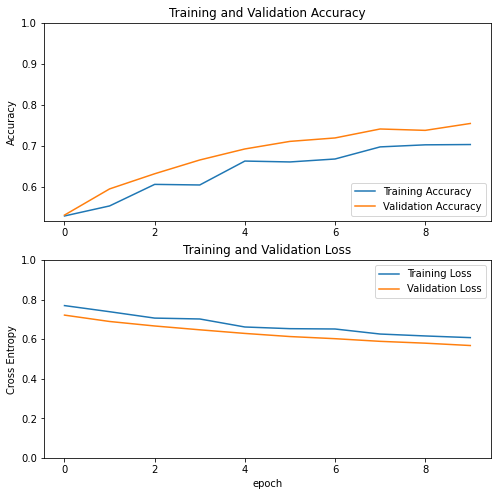

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning 

In [115]:
mobinet_model.trainable = True

In [116]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobinet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobinet_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [117]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [119]:
len(model.trainable_variables)

56

In [120]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(data.X_train, data.y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(data.X_test, data.y_test))

Epoch 10/20
44/44 [==============================] - 93s 2s/step - loss: 0.5654 - accuracy: 0.7244 - val_loss: 0.4948 - val_accuracy: 0.7929
Epoch 11/20
44/44 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.7756

KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(data.X_test, data.y_test)
print('Test accuracy :', accuracy)

In [ ]:
y_pred = model.predict(data.X_test)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(data.y_test, axis=1)

print(accuracy_score(y_test1, y_pred1))
print(confusion_matrix(y_test1,y_pred1))
print(classification_report(y_test1,y_pred1))

### Graph Method for Resnet 101 v2

In [102]:
# print(X_train_val.shape)
# print(y_train_val.shape)
# print(data_train_labels.shape)

In [103]:
# print(X_test_val.shape)
# print(y_test_val.shape)
# print(data_test_labels.shape)

In [104]:
# # test train split

# #Define Model
# model = Sequential()
# model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(128,activation="relu"))
# model.add(Dense(y_train_val.shape[1], activation="sigmoid"))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# history = model.fit(X_train_val, y_train_val, epochs=32, batch_size=16, verbose=2, validation_data=(X_test_val, y_test_val))

# train_loss, train_acc = model.evaluate(X_train_val, y_train_val, verbose=0)
# test_loss, test_acc = model.evaluate(X_test_val, y_test_val, verbose=0)

In [105]:
# model.summary()

In [106]:
# print("Train Loss: " + str(train_loss))
# print("Train Accuracy: " + str(train_acc))

# print("Test Loss: " + str(test_loss))
# print("Test Accuracy: " + str(test_acc))

In [107]:
# y_pred = model.predict(X_test_val)
# y_pred1 = np.argmax(y_pred, axis=1)
# y_test1 = np.argmax(y_test_val, axis=1)

# print(accuracy_score(y_test1, y_pred1))
# print(confusion_matrix(y_test1,y_pred1))
# print(classification_report(y_test1,y_pred1))

In [108]:
# # ploting graph by using values of last epoch for graphs
# from matplotlib import pyplot as plt
# plt.style.use('ggplot')

# def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.ylabel('Accuracy value (%)')
#     plt.xlabel('No. epoch')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.ylabel('Loss value')
#     plt.xlabel('No. epoch')
#     plt.legend()

In [111]:
# plot_history(history)

In [110]:
# #All in one Graph (loss and accuracy)
# plt.style.use('default')
# plt.figure(figsize=(7, 3))
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.plot(history.history["loss"]) 
# plt.plot(history.history["val_loss"]) 
# plt.title("Model Evaluation")
# plt.ylabel("Value (%)")
# plt.xlabel("No. of Epochs")
# plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
# plt.show()